In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from scipy.signal import find_peaks
import scipy.signal.windows as win
import scipy as sp
import warnings
import re
from ipywidgets import interact,widgets
from scipy.optimize import curve_fit
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from scipy.misc import derivative
from matplotlib.colors import hsv_to_rgb
import warnings
from functions_master import *
from glob import glob
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from matplotlib.colors import Normalize

# Suprimir FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)



c = 0.299792458 # speed of light mm/ps

# Reference.

9e-10 

In [2]:
ruta_actual = os.getcwd()

# sample1_ang_csv = os.path.join(ruta_actual,"sample1_ang.csv")
carpeta_sample1 = os.path.join(ruta_actual,"src\\sample1_ang")
carpeta_ref_sample1 = os.path.join(ruta_actual,"src\\reference1")
archivos_dat_ref = glob(os.path.join(os.path.join(carpeta_ref_sample1,'carpeta1'), '*.dat'))
archivos_dat_samp = glob(os.path.join(os.path.join(carpeta_sample1,'carpeta1'), '*.dat'))

# Elimina cada archivo
for archivo in archivos_dat_samp:
    os.remove(archivo)
    print(f'Archivo {archivo} eliminado.')

for archivo in archivos_dat_ref:
    os.remove(archivo)
    print(f'Archivo {archivo} eliminado.')

convert_dats(carpeta_ref_sample1,0)
convert_dats(carpeta_sample1,3)

# Filtrar y ordenar los archivos por la temperatura
archivos_dat_ref = sorted(
    archivos_dat_ref,
    key=lambda x: extraer_temperatura(x)
)

archivos_dat_samp = sorted(
    archivos_dat_samp,
    key=lambda x: extraer_temperatura(x)
)

Archivo c:\Users\esmaru\Desktop\Esteban\repos\mestrado_thz_physics\Materials\analisis_datos_rapido\src\sample1_ang\carpeta1\Average_101.3K.dat eliminado.
Archivo c:\Users\esmaru\Desktop\Esteban\repos\mestrado_thz_physics\Materials\analisis_datos_rapido\src\sample1_ang\carpeta1\Average_123.7K.dat eliminado.
Archivo c:\Users\esmaru\Desktop\Esteban\repos\mestrado_thz_physics\Materials\analisis_datos_rapido\src\sample1_ang\carpeta1\Average_144.6K.dat eliminado.
Archivo c:\Users\esmaru\Desktop\Esteban\repos\mestrado_thz_physics\Materials\analisis_datos_rapido\src\sample1_ang\carpeta1\Average_16.4K.dat eliminado.
Archivo c:\Users\esmaru\Desktop\Esteban\repos\mestrado_thz_physics\Materials\analisis_datos_rapido\src\sample1_ang\carpeta1\Average_164.7K.dat eliminado.
Archivo c:\Users\esmaru\Desktop\Esteban\repos\mestrado_thz_physics\Materials\analisis_datos_rapido\src\sample1_ang\carpeta1\Average_184.4K.dat eliminado.
Archivo c:\Users\esmaru\Desktop\Esteban\repos\mestrado_thz_physics\Materials\

# FULL DATA

In [13]:
from matplotlib import pyplot as plt
from matplotlib import gridspec
from ipywidgets import interact, FloatSlider
import numpy as np
import pandas as pd
import scipy as sp

def anim2(left, right_sample, right_subs, index, desv, d):
    right_ref = right_subs
    N = 2**15

    f = plt.figure(figsize=(10, 8), dpi=200)  # Aumenté el tamaño para 3 subplots

    # Grid: 2 filas, 2 columnas (la última celda ocupará ambas columnas)
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])

    # Subgráficos
    ax1 = plt.subplot(gs[0, 0])  # Señales temporales (original)
    ax2 = plt.subplot(gs[0, 1])  # FFTs (nuevo)
    ax3 = plt.subplot(gs[1, :])  # Absorción (ocupa toda la fila inferior)

    # Ruta del archivo de señal y de referencia
    path_signal = archivos_dat_samp[int(index)]
    path_ref = archivos_dat_ref[0]

    # Ventana y señales procesadas
    params_window1 = ['gaussian', desv]
    phase, y_signal_ventaneada, y_substrate_padding, ventana = getSignalWindowed(
        path_signal, path_ref, left, right_sample, right_subs, params_window1
    )

    # Aplicar ventana
    y_subs_ventana = pd.Series(y_substrate_padding * ventana)
    y_signal_ventaneada = pd.Series(y_signal_ventaneada * ventana)

    val = 2  # Desplazamiento para visualización

    # Señales en dominio temporal (subplot 1)
    ax1.plot(y_subs_ventana / max(y_subs_ventana), 'r', label='Ref')
    ax1.plot(ventana / max(ventana), 'k--', label='Window')
    ax1.plot(y_signal_ventaneada / max(y_signal_ventaneada) + val,'b', label=f'Sam+{extraer_temperatura(path_signal)} K')
    ax1.plot(ventana / max(ventana) + val, 'k--')
    # ax1.set_title("Time Domain Signals")
    ax1.legend(loc='lower right')

    # Dominio de frecuencia
    nu = sp.fft.fftfreq(N, 1/30)
    k = 15
    nu = nu[1:len(nu)//k]

    # Aplicar Fourier y truncar
    fft_y_signal_ventaneada = FourierT2(y_signal_ventaneada, N)[1:len(nu)+1]
    fft_y_subs_ventaneada = FourierT2(y_subs_ventana, N)[1:len(nu)+1]

    # Máscara de frecuencia
    xmin, xmax = 0.2, 1.0
    mask = (nu >= xmin) & (nu <= xmax)
    nu_filtradas = nu[mask]
    fft_y_signal_ventaneada = fft_y_signal_ventaneada[mask]
    fft_y_subs_ventaneada = fft_y_subs_ventaneada[mask]

    # Subplot 2: FFTs
    ax2.plot(nu_filtradas, np.abs(fft_y_signal_ventaneada)**2/np.abs(max(np.abs(fft_y_signal_ventaneada)**2)),'b', label='Sample FFT')
    ax2.plot(nu_filtradas, np.abs(fft_y_subs_ventaneada)**2/np.abs(max(np.abs(fft_y_subs_ventaneada)**2)),'r', label='Reference FFT')
    ax2.set_title("Frequency Domain")
    ax2.set_ylabel("$|FFT|^{2}$")
    ax2.set_xlabel(r"$\nu$ (THz)")
    ax2.legend()

    # Transmitancia y fase
    T = fft_y_signal_ventaneada / fft_y_subs_ventaneada * np.exp(-1j * 2 * np.pi * nu_filtradas * phase / 30)
    
    # Subplot 3: Absorción (ocupa toda la fila inferior)
    ax3.plot(nu_filtradas, -2 / d * np.log(abs(T)),'b')
    ax3.set_ylabel(r"$\alpha$")
    ax3.set_xlabel(r"$\nu$ (THz)")
    ax3.set_title("Absorption Spectrum")
    # ax3.set_yscale('log')  # Descomenta si quieres escala logarítmica

    plt.tight_layout()

# Interfaz interactiva (sin cambios)
opc = dict(continuous_update=False, readout_format=".3f")
interact(anim2,       
    left=FloatSlider(min=40, max=70, value=53, step=0.1, **opc),
    right_sample=FloatSlider(min=50, max=70, value=63.5, step=0.1, **opc),
    right_subs=FloatSlider(min=50, max=70, value=63.5, step=0.1, **opc),
    index=FloatSlider(min=0, max=len(archivos_dat_samp) - 1, value=0, step=1, **opc),
    desv=FloatSlider(min=0, max=1000, value=150, step=0.001, **opc),
    d=FloatSlider(min=0.01, max=1, value=0.627, step=0.01, **opc)
)

interactive(children=(FloatSlider(value=53.0, continuous_update=False, description='left', max=70.0, min=40.0,…

<function __main__.anim2(left, right_sample, right_subs, index, desv, d)>

In [18]:
import matplotlib.animation as animation
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from colorsys import hsv_to_rgb
import matplotlib.cm as cm
from matplotlib.colors import Normalize


def create_frame(index, left, right_sample, right_subs, desv, d, axes, norm, cmap):
    ax1, ax2 = axes

    # Limpiar los ejes en lugar de fig.clear()
    for ax in axes:
        ax.clear()

    path_signal = archivos_dat_samp[int(index)]
    temp = extraer_temperatura(path_signal)
    color = cmap(norm(temp)) if temp is not None else 'blue'
    path_ref = archivos_dat_ref[0]

    N = 2**15
    params_window1 = ['gaussian', desv]

    phase, y_signal_ventaneada, y_substrate_padding, ventana = getSignalWindowed(
        path_signal, path_ref, left, right_sample, right_subs, params_window1)

    y_subs_ventana = pd.Series(y_substrate_padding * ventana)
    y_signal_ventaneada = pd.Series(y_signal_ventaneada * ventana)

    val = 2

    ax1.plot(y_subs_ventana / max(y_subs_ventana), 'k', label='Ref')
    ax1.plot(ventana / max(ventana), 'k--', label='Window')
    ax1.plot(y_signal_ventaneada / max(y_signal_ventaneada) + val, color=color, label=f'Sam+{extraer_temperatura(path_signal)} K')
    ax1.plot(ventana / max(ventana) + val, 'k--')
    # ax1.set_title(f"T = {temp} K" if temp is not None else "Temperatura no disponible")
    ax1.legend(loc='lower right')

    k = 15
    nu = sp.fft.fftfreq(N, 1 / 30)
    fft_y_signal_ventaneada = FourierT2(y_signal_ventaneada, N)[1:len(nu)//k]
    fft_y_subs_ventaneada = FourierT2(y_subs_ventana, N)[1:len(nu)//k]

    nu = nu[1:len(nu)//k]
    xmin, xmax = 0.2, 1.0
    mask = (nu >= xmin) & (nu <= xmax)

    fft_y_signal_ventaneada = fft_y_signal_ventaneada[mask]
    fft_y_subs_ventaneada = fft_y_subs_ventaneada[mask]
    nu_filtradas = nu[mask]

    T = fft_y_signal_ventaneada / fft_y_subs_ventaneada * np.exp(-1j * 2 * np.pi * nu_filtradas * phase * 1 / 30)

    T_exp = abs(T)
    phi_exp = np.unwrap(np.angle(T))

    ax2.plot(nu_filtradas, np.abs(fft_y_signal_ventaneada)**2, color=color)
    
    ax2.set_ylabel(r"$|FFT|^2$")
    # ax2.set_yscale('log')

def generate_gif():
    temps = []
    for path in archivos_dat_samp:
        temp = extraer_temperatura(path)
        if temp is not None:
            temps.append(temp)

    if not temps:
        raise ValueError("No se encontraron temperaturas válidas en los archivos")

    min_temp, max_temp = min(temps), max(temps)
    norm = Normalize(vmin=min_temp, vmax=max_temp)
    cmap = cm.coolwarm

    left = 58.3
    right_sample = 70
    right_subs = 63.5
    desv = 158.0
    d = 0.627

    fig = plt.figure(figsize=(8, 4), dpi=200)
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])

  
    axes = [ax1, ax2]

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    fig.colorbar(sm, cax=cbar_ax, label='Temperature (K)')

    def animate(i):
        create_frame(i, left, right_sample, right_subs, desv, d, axes, norm, cmap)
        return axes
    carpeta = os.getcwd()
    ruta_guardado = os.path.join(carpeta, 'animacion_datos135_gaus.gif')
    ani = animation.FuncAnimation(fig, animate, frames=len(archivos_dat_samp), interval=400, blit=False)
    ani.save(ruta_guardado, writer=animation.PillowWriter(fps=2), dpi=200)
    plt.close()

# Ejecutar
generate_gif()


294.4
276.2
258.4
240.5
222.1
203.4
184.4
164.7
144.6
123.7
101.3
76.1
40.6
16.4


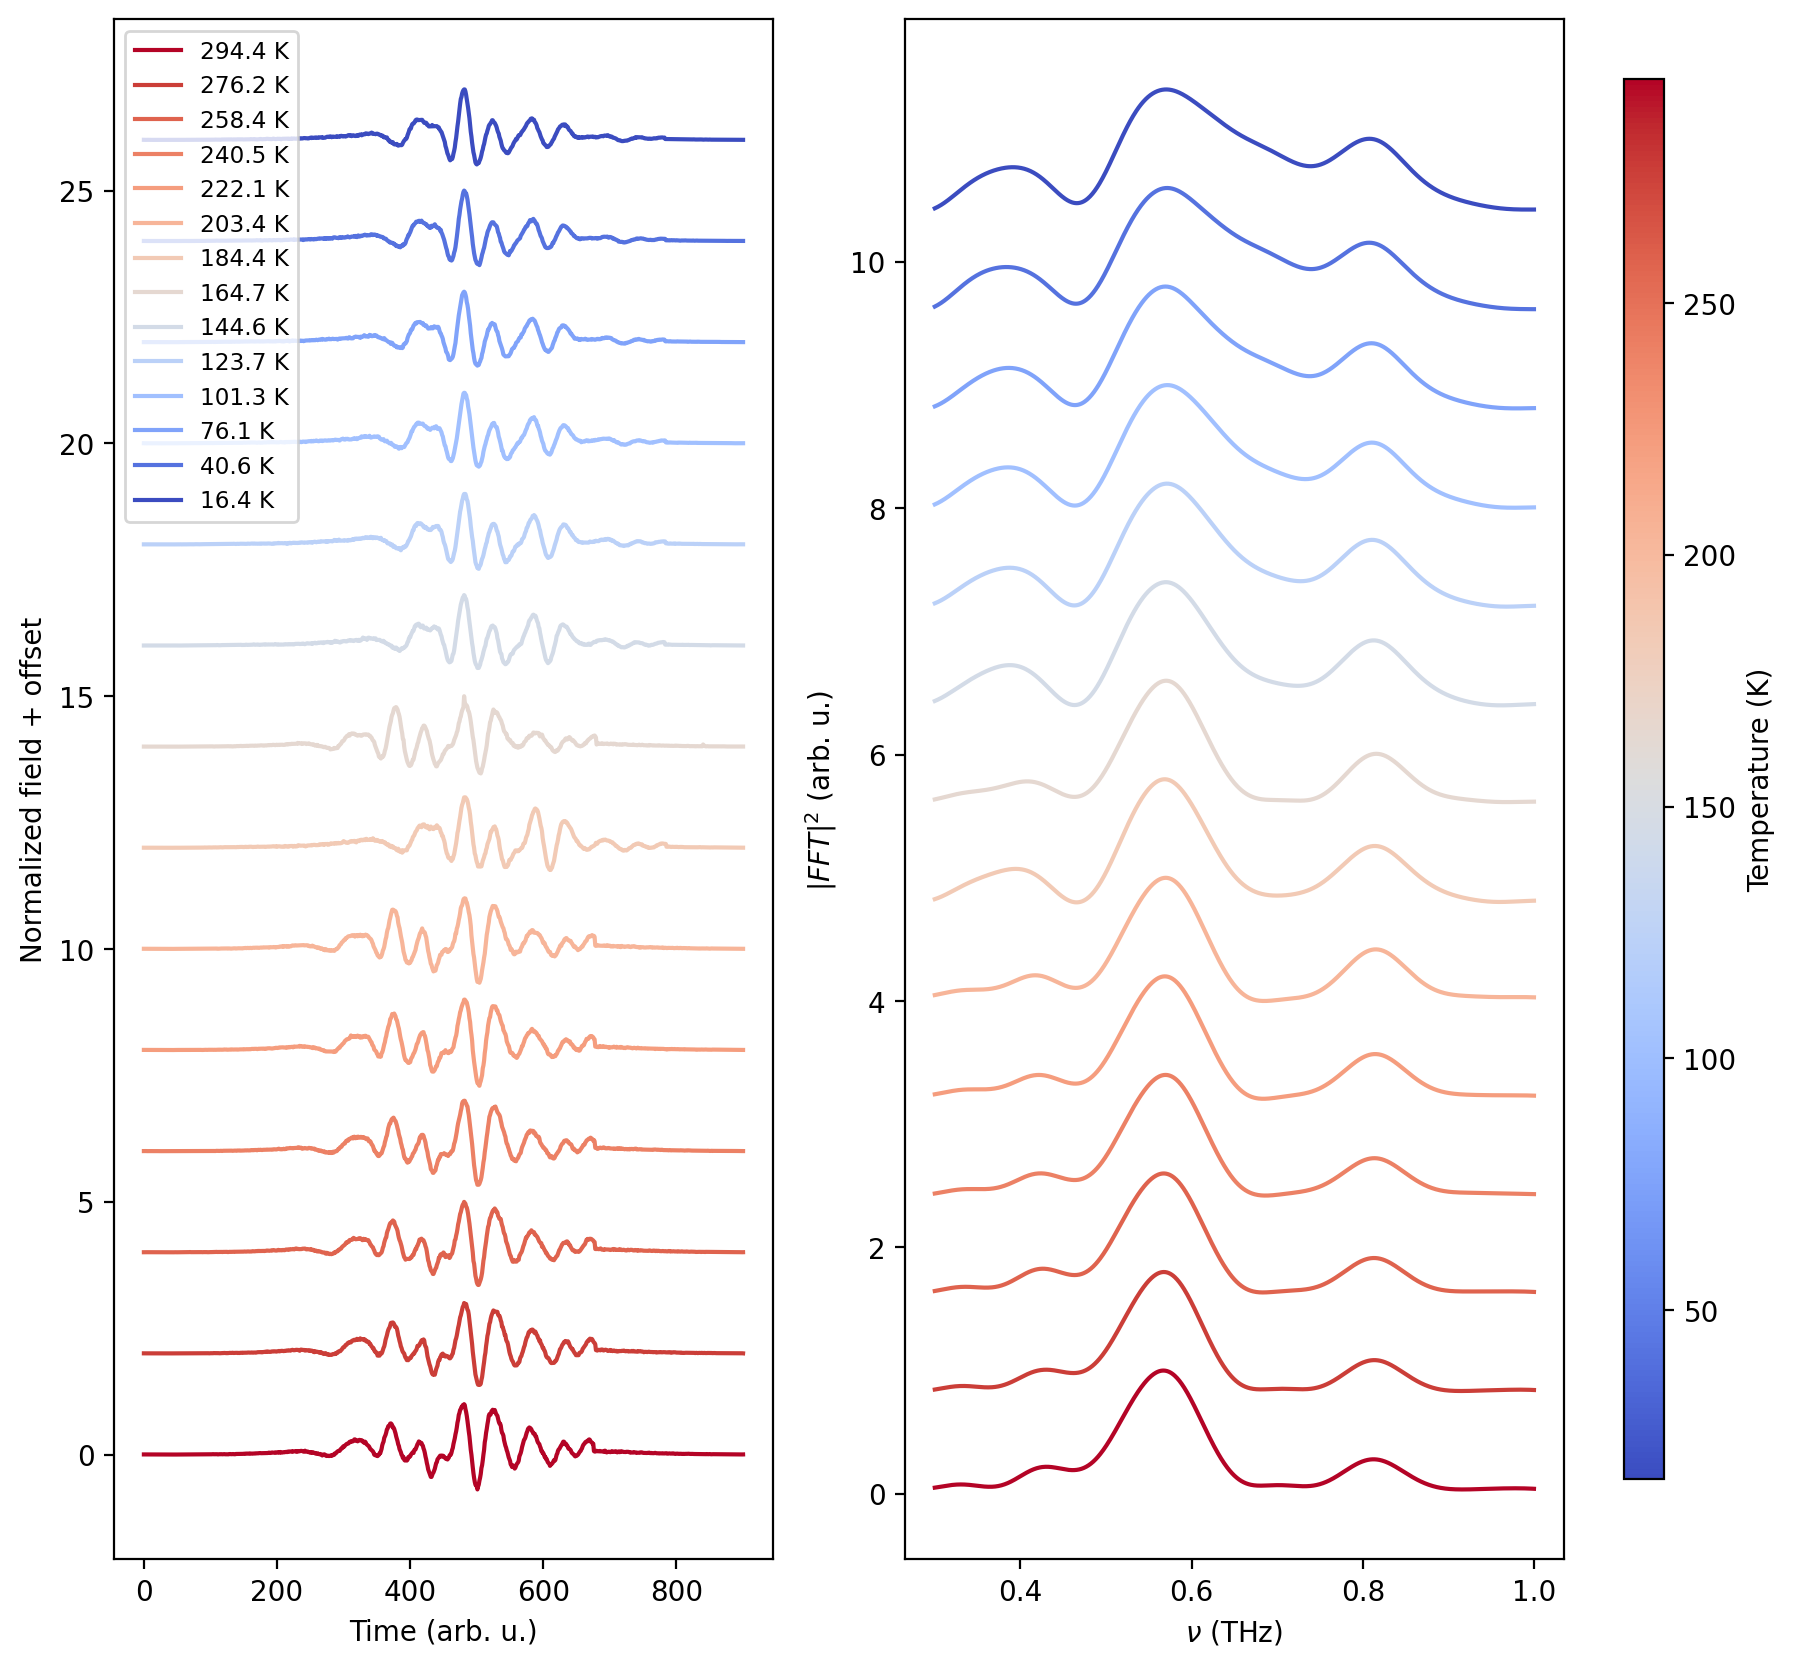

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import cm
from matplotlib.colors import Normalize
import os

def plot_all_samples(left, right_sample, right_subs, desv, d, val_offset_signal=2, val_offset_kappa=0.03):
    temps = [extraer_temperatura(p) for p in archivos_dat_samp if extraer_temperatura(p) is not None][::-1]

    if not temps:
        raise ValueError("No se encontraron temperaturas válidas en los archivos")

    min_temp, max_temp = min(temps), max(temps)
    norm = Normalize(vmin=min_temp, vmax=max_temp)
    cmap = cm.coolwarm

    N = 2**15
    params_window1 = ['gaussian', desv]
    fig, (ax1, ax4) = plt.subplots(1, 2, figsize=(10, 10), dpi=200)

    # ax1.set_title("Señal ventaneada + ventana (todas las muestras)")
    ax1.set_ylabel("Normalized field + offset")
    ax1.set_xlabel("Time (arb. u.)")

    # ax4.set_title(r"Coeficiente de extinción $\kappa$ (todas las muestras)")
    ax4.set_xlabel(r"$\nu$ (THz)")
    ax4.set_ylabel(r"$|FFT|^{2}$ (arb. u.)")

    for index, path_signal in enumerate(archivos_dat_samp):
        temp = temps[index]
        color = cmap(norm(temp)) if temp is not None else 'blue'
        path_ref = archivos_dat_ref[0]

        phase, y_signal_ventaneada, y_substrate_padding, ventana = getSignalWindowed(
            path_signal, path_ref, left, right_sample, right_subs, params_window1)

        y_subs_ventana = pd.Series(y_substrate_padding * ventana)
        y_signal_ventaneada = pd.Series(y_signal_ventaneada * ventana)

        offset_signal = val_offset_signal * index

        # if index == 0:
        #     ax1.plot(y_subs_ventana / max(y_subs_ventana), 'k', label='Ref')
        #     ax1.plot(ventana / max(ventana), 'k--', label='Window')

        ax1.plot(y_signal_ventaneada / max(y_signal_ventaneada) + offset_signal, color=color, label=f'{temp:.1f} K')

        # FFT y kappa
        k = 15
        nu = sp.fft.fftfreq(N, 1 / 30)
        fft_y_signal_ventaneada = FourierT2(y_signal_ventaneada, N)[1:len(nu)//k]
        fft_y_subs_ventaneada = FourierT2(y_subs_ventana, N)[1:len(nu)//k]

        nu = nu[1:len(nu)//k]
        xmin, xmax = 0.3, 1.0
        mask = (nu >= xmin) & (nu <= xmax)

        fft_y_signal_ventaneada = fft_y_signal_ventaneada[mask]
        fft_y_subs_ventaneada = fft_y_subs_ventaneada[mask]
        nu_filtradas = nu[mask]

        #T = fft_y_signal_ventaneada / fft_y_subs_ventaneada * np.exp(-1j * 2 * np.pi * nu_filtradas * phase * 1 / 30)

        val_offset_kappa = 0.8
        offset_kappa = val_offset_kappa * index

        ax4.plot(nu_filtradas, np.abs(fft_y_signal_ventaneada)**2/np.max(np.abs(fft_y_signal_ventaneada)**2) + offset_kappa,
                  color=color, 
                  label=f'{temp:.1f} K')
        print(temp)

    ax1.legend(loc='upper left', fontsize='small')
    # ax4.legend(loc='upper left', fontsize='small')

    # Barra de temperatura al costado
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    fig.colorbar(sm, cax=cbar_ax, label='Temperature (K)')

    plt.show()

# Ejecutar la función
plot_all_samples(left=57.0, right_sample=62, right_subs=61, desv=158.0, d=0.627)


# Sample2

In [26]:
glob(os.path.join(os.path.join(carpeta_ref_sample1,'carpeta1'), '*.dat'))

['c:\\Users\\esteb\\Escritorio\\physics\\mestrado_thz_physics\\Materials\\analisis_datos_rapido (1)\\analisis_datos_rapido\\src\\reference2\\carpeta1\\Average_294.05K.dat']

In [38]:
ruta_actual = os.getcwd()

# sample1_ang_csv = os.path.join(ruta_actual,"sample2_ang.csv")
carpeta_sample1 = os.path.join(ruta_actual,"src\\sample2_ang")
carpeta_ref_sample1 = os.path.join(ruta_actual,"src\\reference2")


archivos_dat_ref = glob(os.path.join(os.path.join(carpeta_ref_sample1,'carpeta1'), '*.dat'))
archivos_dat_samp = glob(os.path.join(os.path.join(carpeta_sample1,'carpeta1'), '*.dat'))


# Elimina cada archivo
for archivo in archivos_dat_samp:
    os.remove(archivo)
    #print(f'Archivo {archivo} eliminado.')

for archivo in archivos_dat_ref:
    os.remove(archivo)
    #print(f'Archivo {archivo} eliminado.')

convert_dats(carpeta_ref_sample1,5)
convert_dats(carpeta_sample1,5)

archivos_dat_ref = glob(os.path.join(os.path.join(carpeta_ref_sample1,'carpeta1'), '*.dat'))
archivos_dat_samp = glob(os.path.join(os.path.join(carpeta_sample1,'carpeta1'), '*.dat'))


# Filtrar y ordenar los archivos por la temperatura
archivos_dat_ref = sorted(
    archivos_dat_ref,
    key=lambda x: extraer_temperatura(x)
)

archivos_dat_samp = sorted(
    archivos_dat_samp,
    key=lambda x: extraer_temperatura(x)
)

Archivo c:\Users\esteb\Escritorio\physics\mestrado_thz_physics\Materials\analisis_datos_rapido (1)\analisis_datos_rapido\src\reference2\carpeta1\Average_294.05K.dat generado en c:\Users\esteb\Escritorio\physics\mestrado_thz_physics\Materials\analisis_datos_rapido (1)\analisis_datos_rapido\src\reference2\carpeta1.
Archivo c:\Users\esteb\Escritorio\physics\mestrado_thz_physics\Materials\analisis_datos_rapido (1)\analisis_datos_rapido\src\sample2_ang\carpeta1\Average_12.2K.dat generado en c:\Users\esteb\Escritorio\physics\mestrado_thz_physics\Materials\analisis_datos_rapido (1)\analisis_datos_rapido\src\sample2_ang\carpeta1.
Archivo c:\Users\esteb\Escritorio\physics\mestrado_thz_physics\Materials\analisis_datos_rapido (1)\analisis_datos_rapido\src\sample2_ang\carpeta1\Average_24.7K.dat generado en c:\Users\esteb\Escritorio\physics\mestrado_thz_physics\Materials\analisis_datos_rapido (1)\analisis_datos_rapido\src\sample2_ang\carpeta1.
Archivo c:\Users\esteb\Escritorio\physics\mestrado_thz_

In [39]:
from matplotlib import pyplot as plt
from matplotlib import gridspec
from ipywidgets import interact, FloatSlider
import numpy as np
import pandas as pd
import scipy as sp

def anim2(left, right_sample, right_subs, index, desv, d):
    right_ref = right_subs
    N = 2**15

    f = plt.figure(figsize=(7, 7), dpi=200)

    # Grid: 1 fila, 2 columnas
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    # Subgráficos
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])

    # Ruta del archivo de señal y de referencia
    path_signal = archivos_dat_samp[int(index)]
    path_ref = archivos_dat_ref[0]

    # Ángulos para colores (si decides usarlos)
    num_files = len(sample1_med)
    angles = np.linspace(0, 360, num_files, endpoint=False)

    # Ventana y señales procesadas
    params_window1 = ['nuttall']
    phase, y_signal_ventaneada, y_substrate_padding, ventana = getSignalWindowed(
        path_signal, path_ref, left, right_sample, right_subs, params_window1
    )

    # Aplicar ventana
    y_subs_ventana = pd.Series(y_substrate_padding * ventana)
    y_signal_ventaneada = pd.Series(y_signal_ventaneada * ventana)

    val = 2  # Desplazamiento para visualización

    # Señales en dominio temporal
    ax1.plot(y_subs_ventana / max(y_subs_ventana), 'k', label='Ref')
    ax1.plot(ventana / max(ventana), 'k--', label='Window')
    ax1.plot(y_signal_ventaneada / max(y_signal_ventaneada) + val, label='Sam')
    ax1.plot(ventana / max(ventana) + val, 'k--')

    ax1.set_title("Signals")
    ax1.legend(loc='lower right')

    # Dominio de frecuencia
    # Crear eje de frecuencias
    nu = sp.fft.fftfreq(N, 1/30)
    k = 15

    # Truncar a las primeras len(nu)//k frecuencias (quitando el 0)
    nu = nu[1:len(nu)//k]  # Esto ahora tiene len = M

    # Aplicar Fourier y truncar igual
    fft_y_signal_ventaneada = FourierT2(y_signal_ventaneada, N)[1:len(nu)+1]
    fft_y_subs_ventaneada   = FourierT2(y_subs_ventana, N)[1:len(nu)+1]

    # Ahora sí aplicar máscara de frecuencia
    xmin, xmax = 0.15, 1.0
    mask = (nu >= xmin) & (nu <= xmax)

    # Filtrar
    nu_filtradas = nu[mask]
    fft_y_signal_ventaneada = fft_y_signal_ventaneada[mask]
    fft_y_subs_ventaneada = fft_y_subs_ventaneada[mask]

    # Transmitancia y fase
    T = fft_y_signal_ventaneada / fft_y_subs_ventaneada * np.exp(-1j * 2 * np.pi * nu_filtradas * phase / 30)
    # T_exp = abs(T)
    phi_exp = np.unwrap(np.angle(T))

    # Absorción
    ax2.plot(nu_filtradas, -2 / d * np.log(abs(T)),label=f'{extraer_temperatura(path_signal)} K')
    ax2.set_ylabel(r"$\alpha$")
    ax2.set_xlabel(r"$\nu$ (THz)")
    # ax2.set_yscale('log')
    ax2.legend(loc='upper right')

    plt.tight_layout()

# Interfaz interactiva
opc = dict(continuous_update=False, readout_format=".3f")
interact(anim2,       
    left=FloatSlider(min=40, max=70, value=53, step=0.1, **opc),
    right_sample=FloatSlider(min=50, max=70, value=63.5, step=0.1, **opc),
    right_subs=FloatSlider(min=50, max=70, value=63.5, step=0.1, **opc),
    index=FloatSlider(min=0, max=len(archivos_dat_samp) - 1, value=0, step=1, **opc),
    desv=FloatSlider(min=0, max=1000, value=150, step=0.001, **opc),
    d=FloatSlider(min=0.01, max=1, value=0.627, step=0.01, **opc)
)


interactive(children=(FloatSlider(value=53.0, continuous_update=False, description='left', max=70.0, min=40.0,…

<function __main__.anim2(left, right_sample, right_subs, index, desv, d)>

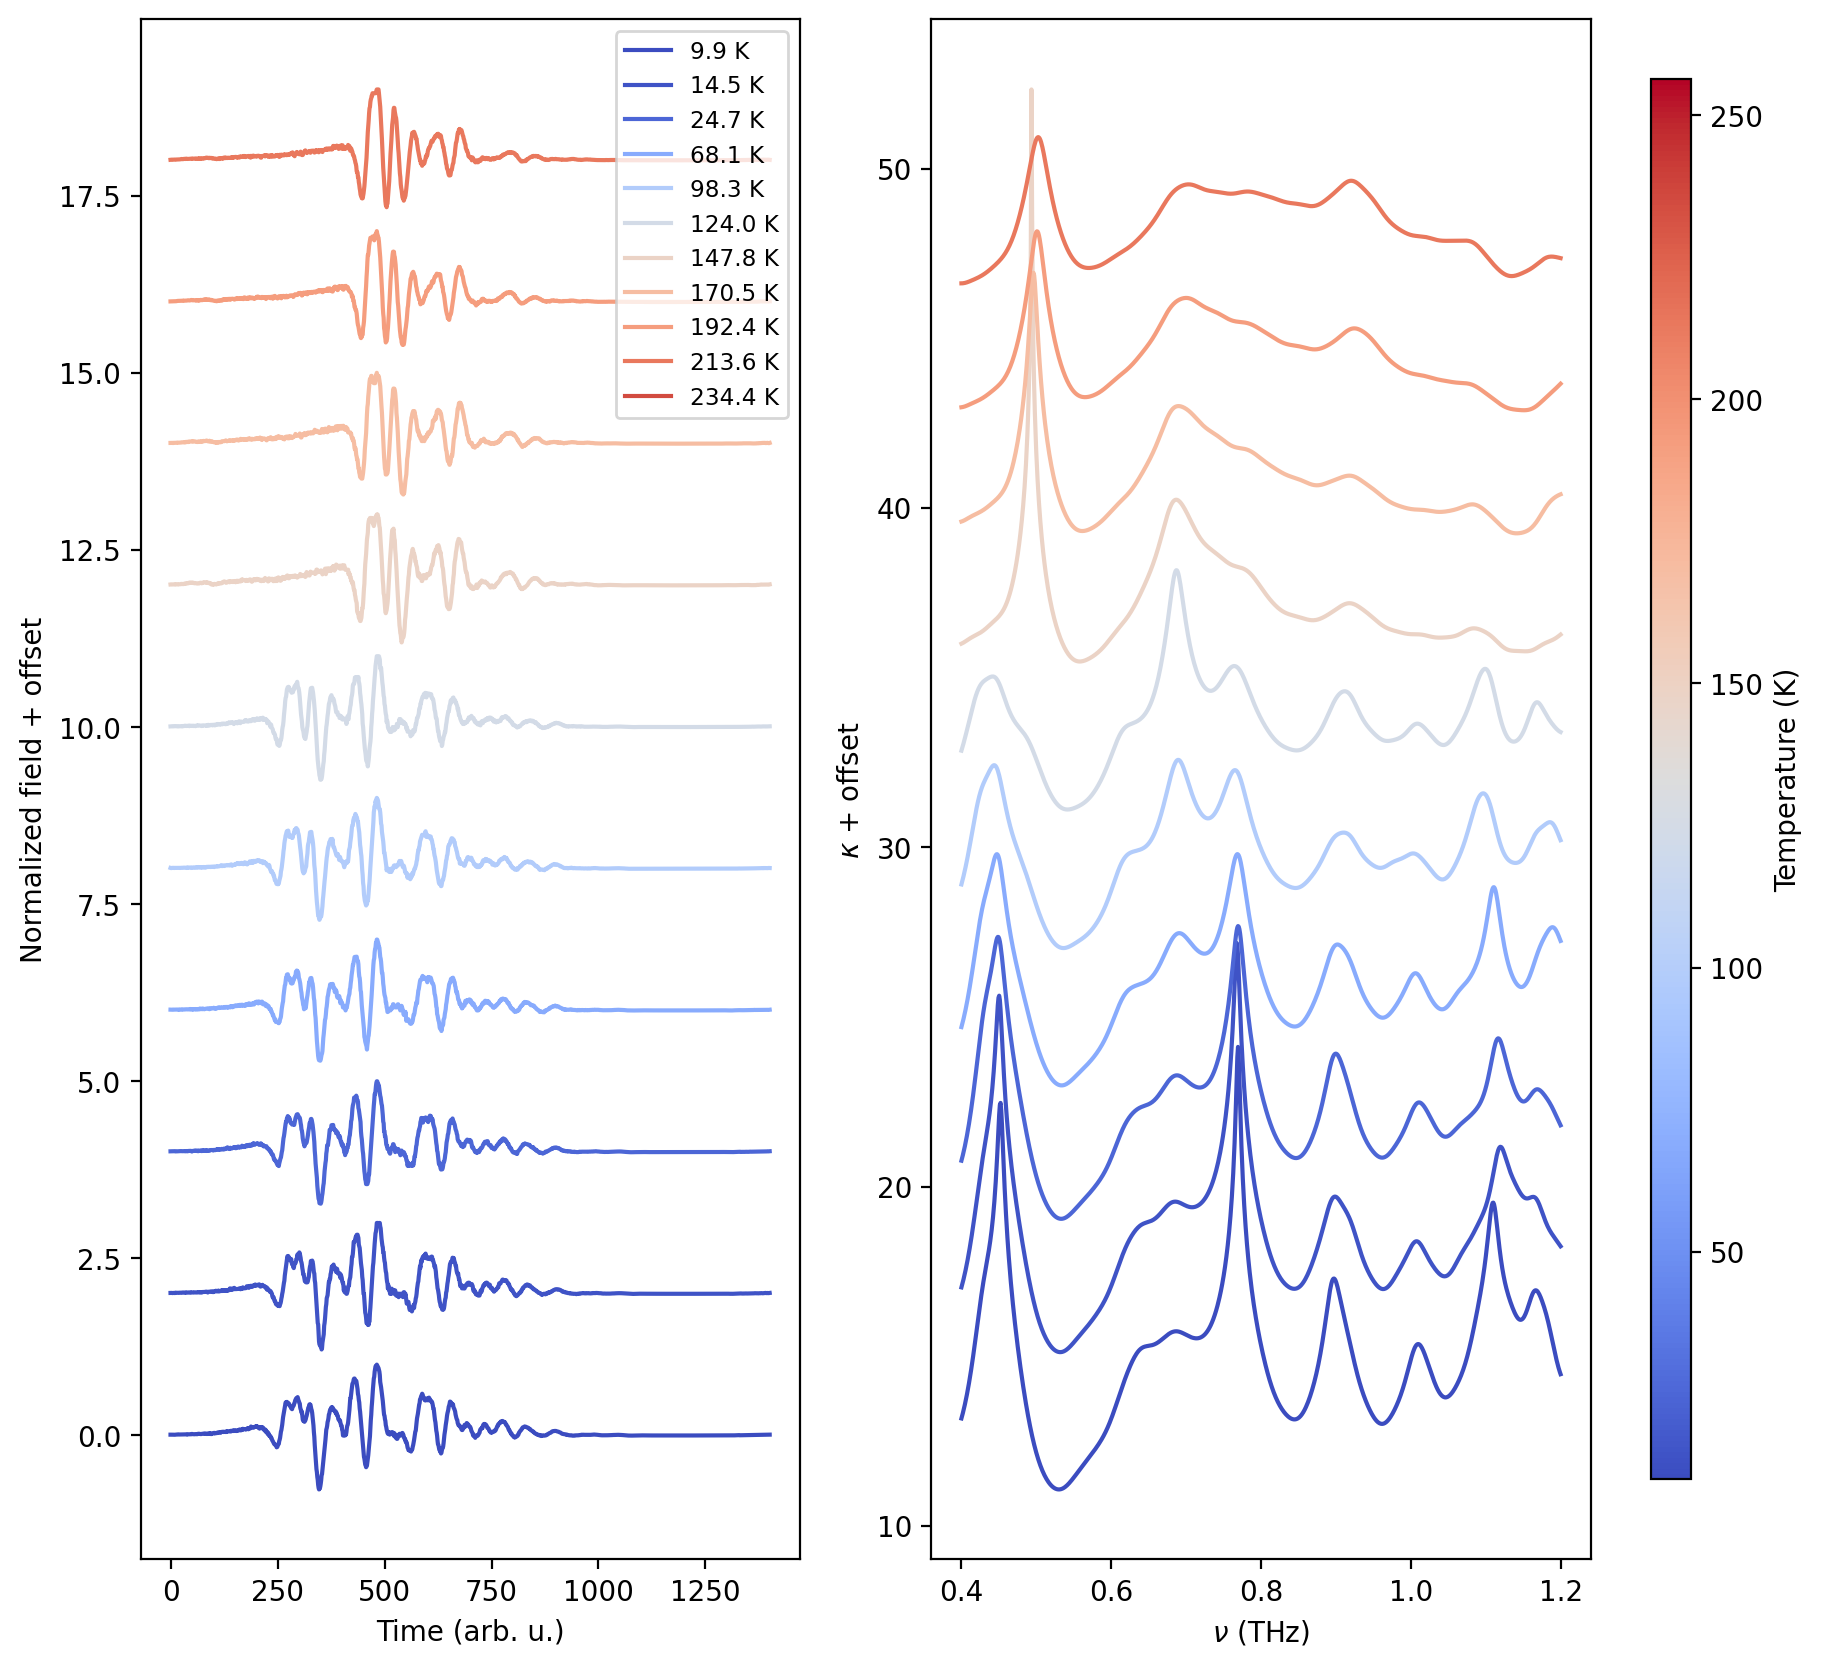

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import cm
from matplotlib.colors import Normalize
import os

def plot_all_samples(left, right_sample, right_subs, desv, d, val_offset_signal=2, val_offset_kappa=0.03):
    temps = [extraer_temperatura(p) for p in sample1_med if extraer_temperatura(p) is not None][::-1]

    if not temps:
        raise ValueError("No se encontraron temperaturas válidas en los archivos")

    min_temp, max_temp = min(temps), max(temps)
    norm = Normalize(vmin=min_temp, vmax=max_temp)
    cmap = cm.coolwarm

    N = 2**15
    params_window1 = ['nuttall']
    fig, (ax1, ax4) = plt.subplots(1, 2, figsize=(10, 10), dpi=200)

    # ax1.set_title("Señal ventaneada + ventana (todas las muestras)")
    ax1.set_ylabel("Normalized field + offset")
    ax1.set_xlabel("Time (arb. u.)")

    # ax4.set_title(r"Coeficiente de extinción $\kappa$ (todas las muestras)")
    ax4.set_xlabel(r"$\nu$ (THz)")
    ax4.set_ylabel(r"$\kappa$ + offset")

    for index, path_signal in enumerate(archivos_dat_samp):
        temp = temps[index]
        color = cmap(norm(temp)) if temp is not None else 'blue'
        path_ref = archivos_dat_ref[0]

        phase, y_signal_ventaneada, y_substrate_padding, ventana = getSignalWindowed(
            path_signal, path_ref, left, right_sample, right_subs, params_window1)

        y_subs_ventana = pd.Series(y_substrate_padding * ventana)
        y_signal_ventaneada = pd.Series(y_signal_ventaneada * ventana)

        offset_signal = val_offset_signal * index

        # if index == 0:
        #     ax1.plot(y_subs_ventana / max(y_subs_ventana), 'k', label='Ref')
        #     ax1.plot(ventana / max(ventana), 'k--', label='Window')

        ax1.plot(y_signal_ventaneada / max(y_signal_ventaneada) + offset_signal, color=color, label=f'{temp:.1f} K')

        # FFT y kappa
        k = 15
        nu = sp.fft.fftfreq(N, 1 / 30)
        fft_y_signal_ventaneada = FourierT2(y_signal_ventaneada, N)[1:len(nu)//k]
        fft_y_subs_ventaneada = FourierT2(y_subs_ventana, N)[1:len(nu)//k]

        nu = nu[1:len(nu)//k]
        xmin, xmax = 0.4, 1.2
        mask = (nu >= xmin) & (nu <= xmax)

        fft_y_signal_ventaneada = fft_y_signal_ventaneada[mask]
        fft_y_subs_ventaneada = fft_y_subs_ventaneada[mask]
        nu_filtradas = nu[mask]

        T = fft_y_signal_ventaneada / fft_y_subs_ventaneada * np.exp(-1j * 2 * np.pi * nu_filtradas * phase * 1 / 30)

        val_offset_kappa = 4
        offset_kappa = val_offset_kappa * index

        ax4.plot(nu_filtradas, -2 / d * np.log(abs(T)) + offset_kappa, color=color, label=f'{temp:.1f} K')

    ax1.legend(loc='upper right', fontsize='small')
    # ax4.legend(loc='upper left', fontsize='small')

    # Barra de temperatura al costado
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    fig.colorbar(sm, cax=cbar_ax, label='Temperature (K)')

    plt.show()

# Ejecutar la función
plot_all_samples(left=57.0, right_sample=68, right_subs=65, desv=150.0, d=0.627)
